Cel projektu: Przewidywanie poziomu ryzyka wypadku (accident_risk) na podstawie parametrów infrastruktury drogowej (np. road_type, speed_limit) oraz warunków zewnętrznych (np. weather, lighting).

Źródło danych: https://www.kaggle.com/datasets/chetanmittal033/road-accident-dataset

Do projektu wycięto 10 tysięcy danych ze zbioru train.csv.

In [34]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [35]:
df = pd.read_csv("./archive/data.csv", encoding='utf-16')

## Analiza danych

In [36]:
df.head(5)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  int64  
 1   road_type               10000 non-null  object 
 2   num_lanes               10000 non-null  int64  
 3   curvature               10000 non-null  float64
 4   speed_limit             10000 non-null  int64  
 5   lighting                10000 non-null  object 
 6   weather                 10000 non-null  object 
 7   road_signs_present      10000 non-null  bool   
 8   public_road             10000 non-null  bool   
 9   time_of_day             10000 non-null  object 
 10  holiday                 10000 non-null  bool   
 11  school_season           10000 non-null  bool   
 12  num_reported_accidents  10000 non-null  int64  
 13  accident_risk           10000 non-null  float64
dtypes: bool(4), float64(2), int64(4), objec

Rozkłady zmiennej celu (y = accident_risk) oraz zmiennych objaśniających numerycznych

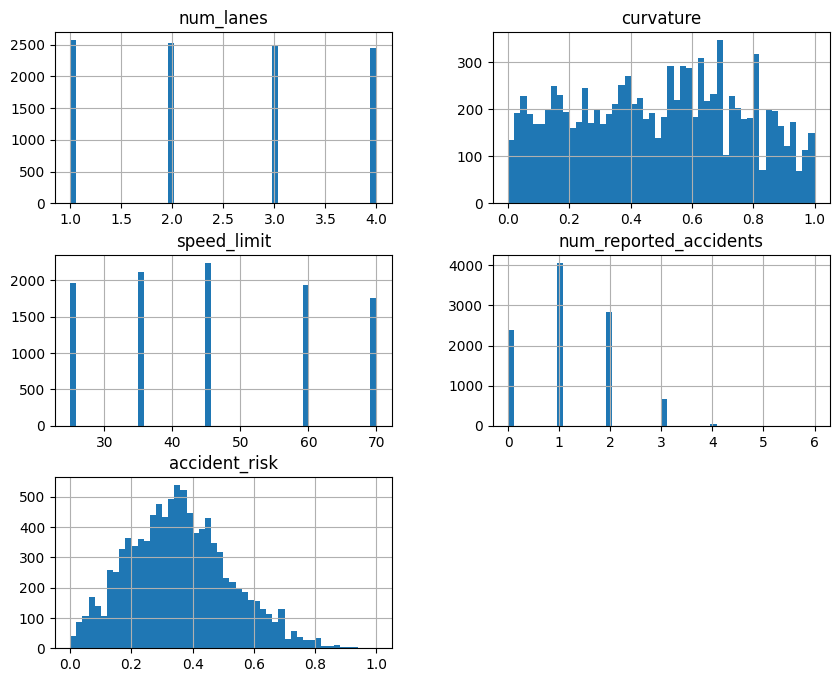

In [38]:
df.hist(bins=50, figsize=(10,8), column=[col for col in df.columns if col != 'id'])
plt.show()

Rozkład ryzyka jest zbliżony do normalnego, jednak widać lekką asymetrię prawostronną. Większość dróg ma niskie lub średnie ryzyko, a ekstremalnie niebezpieczne odcinki są rzadsze, co jest naturalne dla rzeczywistych danych drogowych.

Rozkłady zmiennych objaśniających kategorycznych

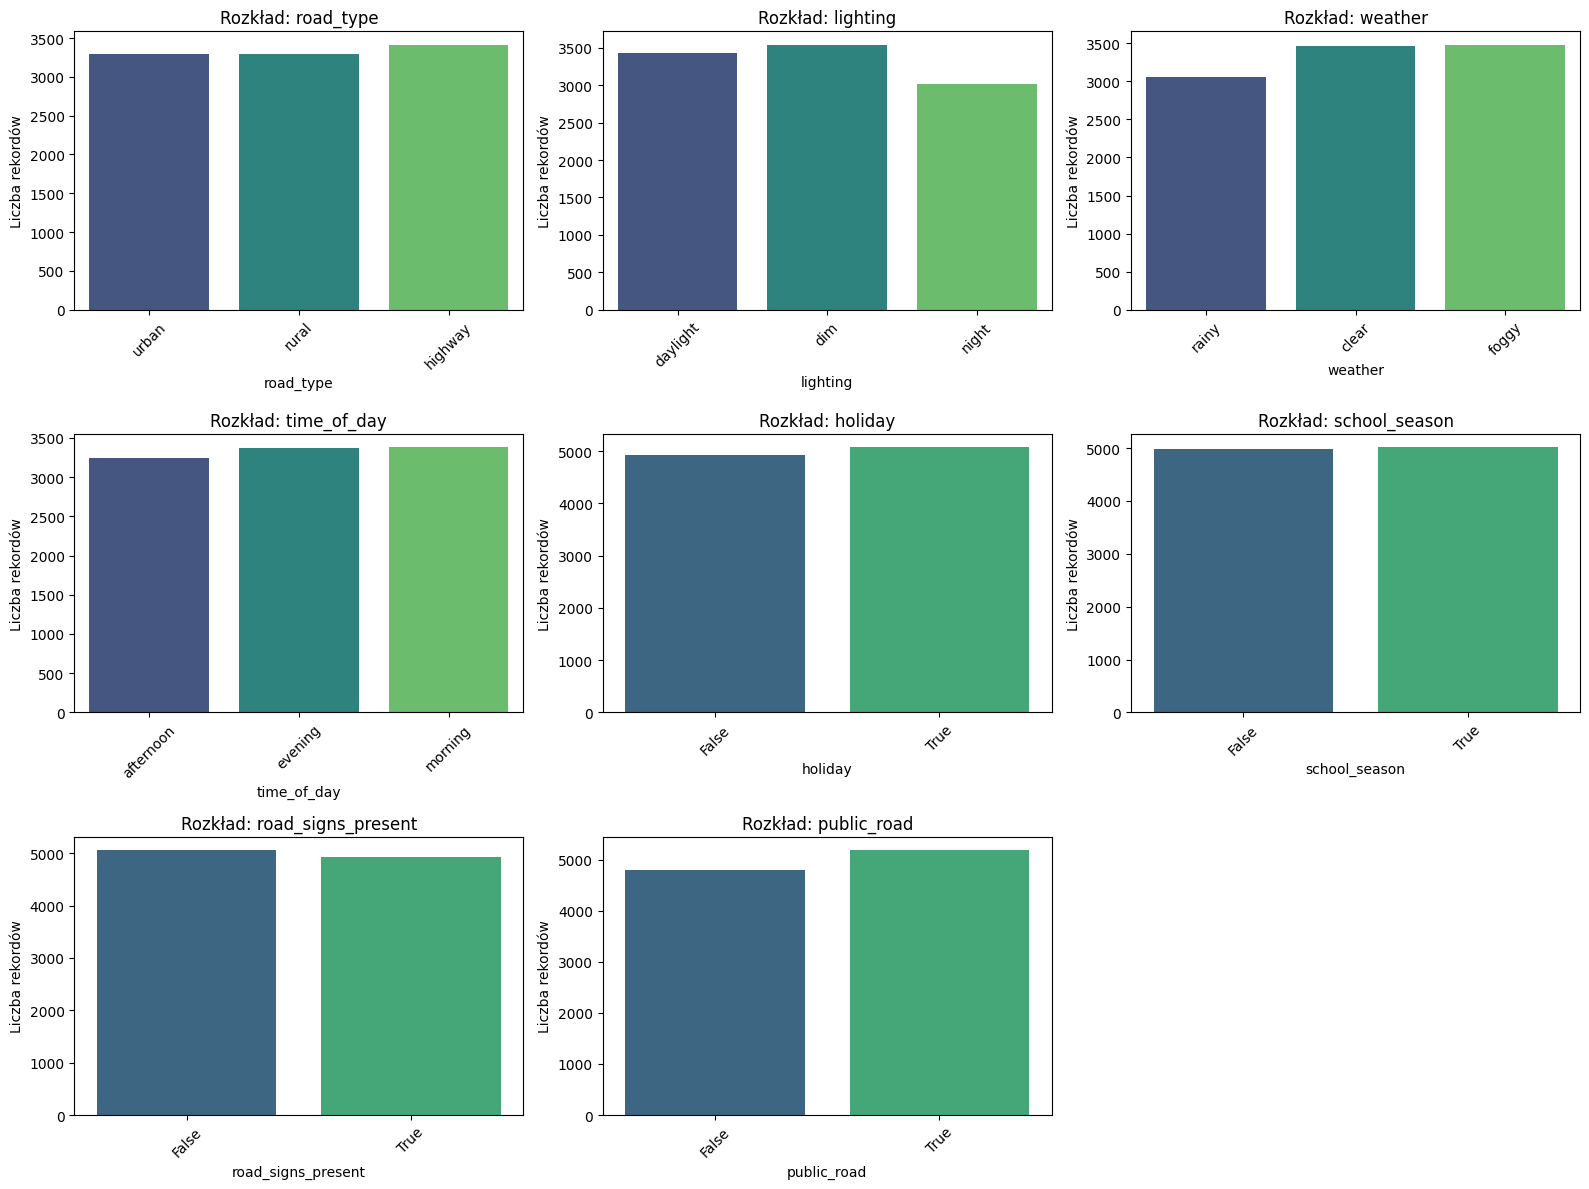


Statystyki dla road_type:
road_type
highway    3416
urban      3292
rural      3292
Name: count, dtype: int64

Statystyki dla lighting:
lighting
dim         3544
daylight    3434
night       3022
Name: count, dtype: int64

Statystyki dla weather:
weather
foggy    3483
clear    3462
rainy    3055
Name: count, dtype: int64

Statystyki dla time_of_day:
time_of_day
morning      3382
evening      3378
afternoon    3240
Name: count, dtype: int64

Statystyki dla holiday:
holiday
True     5077
False    4923
Name: count, dtype: int64

Statystyki dla school_season:
school_season
True     5017
False    4983
Name: count, dtype: int64

Statystyki dla road_signs_present:
road_signs_present
False    5063
True     4937
Name: count, dtype: int64

Statystyki dla public_road:
public_road
True     5192
False    4808
Name: count, dtype: int64


In [39]:
# 1. Definicja kolumn kategorycznych
# Wybieramy te, które mają typ 'object' lub są logiczne (bool)
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 
                    'holiday', 'school_season', 'road_signs_present', 'public_road']

# 2. Tworzenie zbiorczego wykresu dla zmiennych kategorycznych
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    # countplot pokazuje liczebność każdej kategorii
    sns.countplot(data=df, x=col, palette='viridis', hue=col, legend=False)
    plt.title(f'Rozkład: {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Liczba rekordów')

plt.tight_layout()
plt.show()

# 3. Wyświetlenie dokładnych wartości liczbowych w konsoli
for col in categorical_cols:
    print(f"\nStatystyki dla {col}:")
    print(df[col].value_counts())

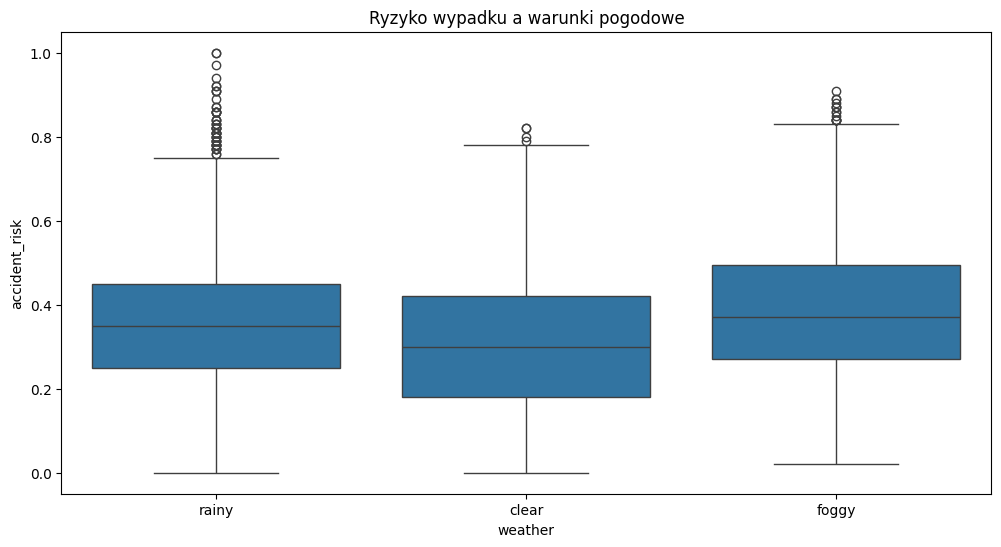

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a warunki pogodowe')
plt.show()

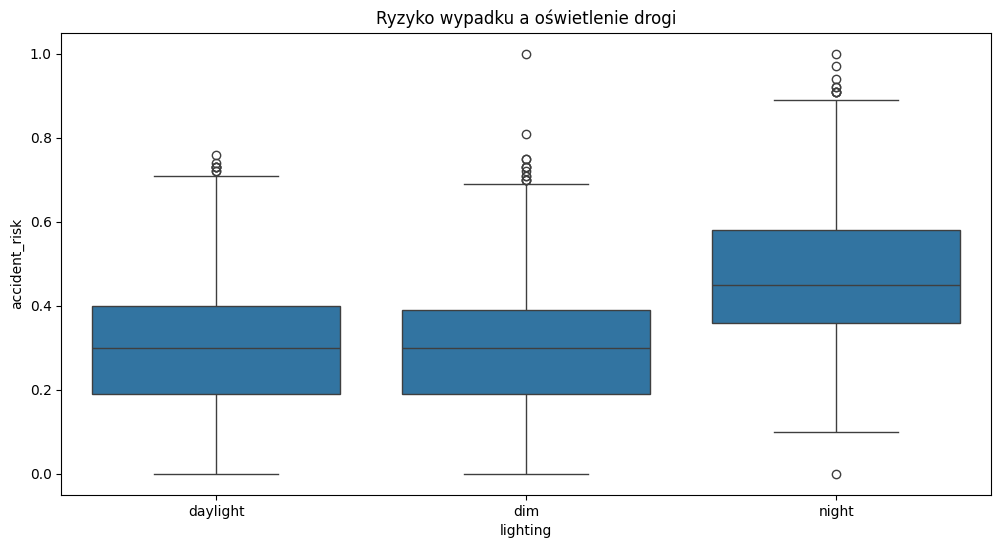

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='lighting', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a oświetlenie drogi')
plt.show()

Analiza wykresu pudełkowego dla zmiennej lighting wykazała istotne różnice w rozkładzie ryzyka. Mediana ryzyka dla warunków nocnych (night) jest o ok. 15% wyższa niż w przypadku światła dziennego. Dodatkowo, warunki nocne charakteryzują się większą zmiennością (szersze pudełko), co sugeruje, że brak oświetlenia jest jednym z kluczowych czynników wpływających na niepewność modelu. Punkty nad "wąsami" (outliery) to wartości odstające. Pokazują one, że nawet w dzień (daylight) zdarzają się sytuacje o bardzo wysokim ryzyku (powyżej 0.7), mimo że typowe ryzyko jest niskie.

<Axes: xlabel='curvature', ylabel='accident_risk'>

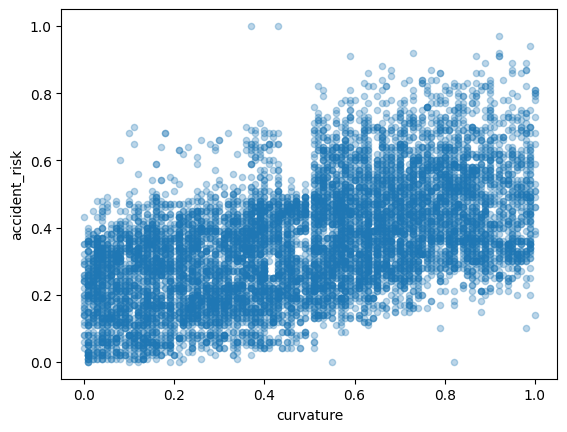

In [42]:
df.plot(kind='scatter', x='curvature',y='accident_risk', alpha=0.3)

Wykres rozrzutu z linią regresji wykazuje wyraźną korelację dodatnią między zakrzywieniem drogi a ryzykiem wypadku. Sugeruje to, że bardziej kręte odcinki dróg są trudniejsze dla kierowców i generują wyższe prawdopodobieństwo zdarzeń drogowych.

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

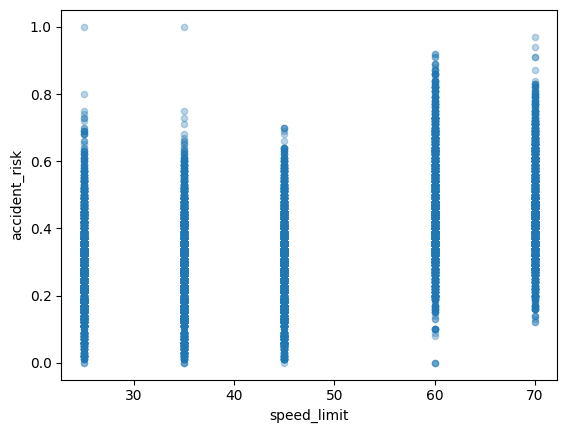

In [43]:
df.plot(kind='scatter', x='speed_limit',y='accident_risk', alpha=0.3)

Istnieje wyraźna dodatnia korelacja między dopuszczalną prędkością a ryzykiem wypadku.

<Axes: >

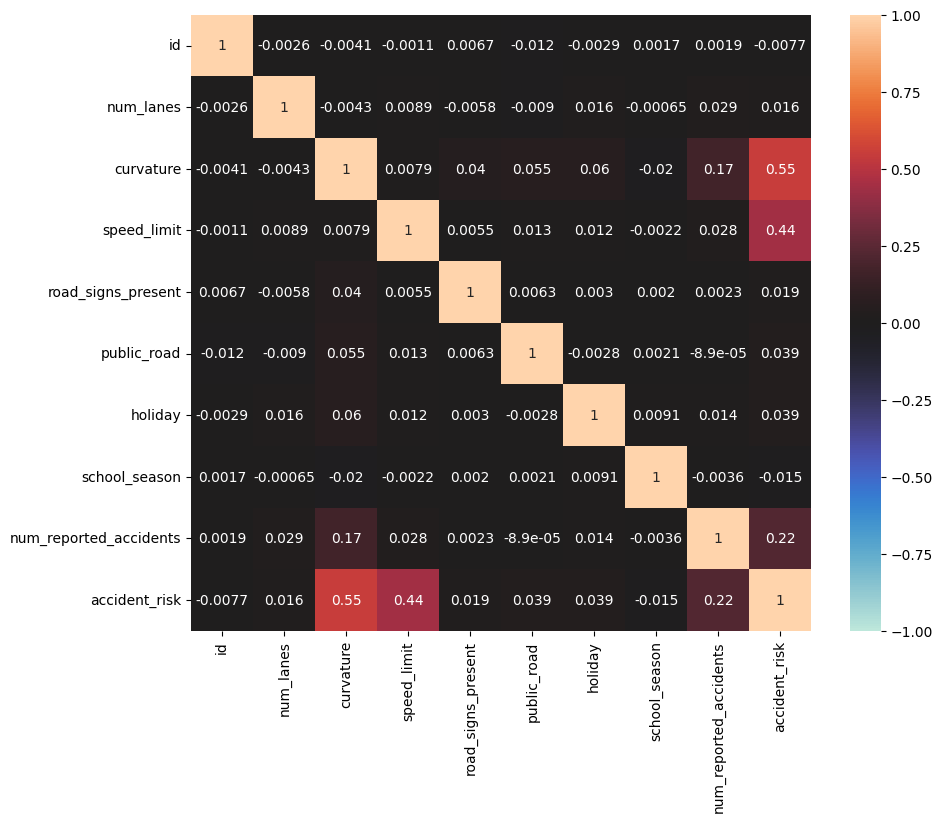

In [44]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True)

Kolejno krzywizna drogi oraz ograniczenie prędkości mają najsilniejszy wpływ na ryzyko.

## Przygotowanie danych do modelu

In [45]:
# Usuwamy zbędne kolumny
df_cleaned = df.drop(['id', 'num_reported_accidents'], axis=1)

In [46]:
df_cleaned.isna().sum()

road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
holiday               0
school_season         0
accident_risk         0
dtype: int64

In [47]:
onehot_encoder = OneHotEncoder()

columns_to_encode = ['road_type', 'lighting', 'weather', 'time_of_day']
data_to_encode = df_cleaned[columns_to_encode]
encoded_data = onehot_encoder.fit_transform(data_to_encode).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(input_features=columns_to_encode), index=data_to_encode.index)
df_onehotencoder = pd.concat([df_cleaned.drop(columns_to_encode, axis=1), encoded_df], axis=1)

# Zamiana wartości logicznych/binarnych na 0 i 1
binary_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in binary_cols:
    df_onehotencoder[col] = df_onehotencoder[col].astype(int)

onehot_columns=df_onehotencoder.columns.tolist()
print(df_onehotencoder.columns.tolist())
df_onehotencoder.head(5)


['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'accident_risk', 'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning']


,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,accident_risk,road_type_highway,road_type_rural,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,2,0.06,35,0,1,0,1,0.13,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,4,0.99,35,1,0,1,1,0.35,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,0.63,70,0,1,1,0,0.30,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,0.07,35,1,1,0,0,0.21,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.58,60,0,0,1,0,0.56,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [48]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_onehotencoder[onehot_columns]) 
print(np_scaled)

normalizer = Normalizer()
np_scaled_normalized = normalizer.fit_transform(np_scaled)
print(np_scaled_normalized)

df_scaled = pd.DataFrame(np_scaled_normalized)
df_scaled.columns = onehot_columns

df_scaled.head(5)

X = df_scaled[['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning']]
y = df_scaled['accident_risk']

[[-0.42774822 -1.56163365 -0.71047841 ...  1.44444444 -0.71422531
  -0.71486399]
 [ 1.36087072  1.85969163 -0.71047841 ... -0.69230769  1.40011841
  -0.71486399]
 [ 1.36087072  0.53530765  1.49764167 ... -0.69230769 -0.71422531
   1.3988675 ]
 ...
 [ 0.46656125  1.7493263   0.86675022 ...  1.44444444 -0.71422531
  -0.71486399]
 [ 1.36087072 -0.53155722 -0.07958696 ... -0.69230769 -0.71422531
   1.3988675 ]
 [-1.32205769  0.86640365 -1.34136986 ...  1.44444444 -0.71422531
  -0.71486399]]
[[-0.09284356 -0.33895554 -0.15421068 ...  0.3135194  -0.15502396
  -0.15516258]
 [ 0.29255134  0.39978469 -0.15273413 ... -0.14882791  0.30098856
  -0.15367692]
 [ 0.30434523  0.11971625  0.3349327  ... -0.15482775 -0.1597294
   0.31284284]
 ...
 [ 0.10001333  0.37499033  0.18579893 ...  0.30963503 -0.15310327
  -0.15324018]
 [ 0.31786256 -0.12415738 -0.01858936 ... -0.16170434 -0.1668237
   0.32673758]
 [-0.290431    0.19033245 -0.29467352 ...  0.31731705 -0.15690176
  -0.15704206]]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

## Uczenie

### Machine Learning

In [50]:
regressors = {}
regressors['LinReg'] =LinearRegression()
regressors['Ridge'] = Ridge(alpha = .5)
regressors['Lasso'] = Lasso(alpha = 5.1)
regressors['ElNet'] =ElasticNet(alpha = .5, l1_ratio=0.5)
fit_results={}
for key in regressors:
    regr = regressors[key]
    regr.fit(X_train, y_train)
    # mean square error
    mse = mean_squared_error(y_test, regr.predict(X_test)) 
    rmse = np.sqrt(mean_squared_error(y_test, regr.predict(X_test)))
    r2score = r2_score(y_test, regr.predict(X_test))
    fit_results[key]= { 'MSE': mse, 'RMSE': rmse, 'R^2': r2score}
    print("{}\n----------\n  MSE={}\n  RMSE={}\n  R^2={}\n ".format(key,mse,rmse,r2score))

LinReg
----------
  MSE=0.009755725945743041
  RMSE=0.09877107848830569
  R^2=0.7909859212455971
 
Ridge
----------
  MSE=0.009755456305233405
  RMSE=0.09876971350182912
  R^2=0.7909916982285741
 
Lasso
----------
  MSE=0.04667826293111916
  RMSE=0.21605152841653114
  R^2=-7.054099966041782e-05
 
ElNet
----------
  MSE=0.04667826293111916
  RMSE=0.21605152841653114
  R^2=-7.054099966041782e-05
 


In [51]:
DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_train)
y_pred_dt = DTR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mse = mean_squared_error(y_test, y_pred_dt)
r2score = r2_score(y_test, y_pred_dt)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)
print('R^2: %.2f'% r2score)


MSE: 0.01
RMSE: 0.09
R^2: 0.84


In [ ]:
DTR.feature_importances_

array([0.02025309, 0.32207057, 0.21396334, 0.00397674, 0.00553493,
       0.00501173, 0.0048711 , 0.00367713, 0.0037072 , 0.00332319,
       0.00575862, 0.00311975, 0.28919002, 0.08075192, 0.01066486,
       0.01228494, 0.00523217, 0.00311994, 0.00348875])

In [53]:
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)
y_pred_rf = RFR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
r2score = r2_score(y_test, y_pred_rf)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)
print('R^2: %.2f'% r2score)


MSE: 0.00
RMSE: 0.06
R^2: 0.91


In [54]:
RFR.feature_importances_

array([0.02045768, 0.32077733, 0.21696687, 0.00467617, 0.00538219,
       0.00512572, 0.00506793, 0.00415688, 0.00379174, 0.00388943,
       0.00404254, 0.0040381 , 0.28838423, 0.08190022, 0.00809143,
       0.0106178 , 0.00446558, 0.00404141, 0.00412678])

In [55]:
GBR = GradientBoostingRegressor()
GBR.fit(X_train,y_train)
y_pred_rf = GBR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
r2score = r2_score(y_test, y_pred_rf)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)
print('R^2: %.2f'% r2score)

MSE: 0.01
RMSE: 0.07
R^2: 0.88


In [56]:
GBR.feature_importances_

array([5.66891176e-03, 3.43532419e-01, 2.38958218e-01, 9.43009179e-05,
       1.20629290e-04, 1.90906481e-04, 1.38832929e-04, 2.72385037e-04,
       1.01343874e-04, 3.68814031e-04, 6.84041618e-03, 7.97016593e-03,
       3.15388634e-01, 7.55094059e-02, 3.00358810e-03, 6.66343391e-04,
       2.68449098e-04, 5.42488840e-04, 3.63747455e-04])

In [57]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_svr_pred = svr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_svr_pred))
mse = mean_squared_error(y_test, y_svr_pred)
r2score = r2_score(y_test, y_svr_pred)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)
print('R^2: %.2f'% r2score)

MSE: 0.01
RMSE: 0.09
R^2: 0.82


In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_knn_pred = knn_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_knn_pred))
mse = mean_squared_error(y_test, y_knn_pred)
r2score = r2_score(y_test, y_knn_pred)
print('MSE: %.2f'% mse)
print('RMSE: %.2f'% rmse)
print('R^2: %.2f'% r2score)

MSE: 0.02
RMSE: 0.12
R^2: 0.67


Wniosek: Ocena modelu Random Forest (ML)

Skuteczność modelu: Algorytm Random Forest okazał się znacznie lepszy od regresji liniowej, podnosząc współczynnik determinacji z $0.79$ do $0.91$. Świadczy to o tym, że zależności w zbiorze danych mają charakter nieliniowy, a drzewa decyzyjne lepiej radzą sobie z wyłapywaniem interakcji między cechami (np. jednoczesny wpływ wysokiej prędkości i braku oświetlenia).

Precyzja przewidywań (RMSE): Błąd RMSE na poziomie 0.06 oznacza, że średnie odchylenie przewidywań modelu od rzeczywistego ryzyka wynosi zaledwie 6% w skali całego zbioru. Jest to wynik bardzo wysoki, pozwalający na realne zastosowanie modelu do oceny bezpieczeństwa dróg.

Stabilność (MSE): Wartość MSE bliska 0.00 wskazuje, że model rzadko popełnia błędy o dużej skali (tzw. outliery błędu), co jest kluczowe w systemach bezpieczeństwa drogowego.